# Benchmarks

## Utils 

In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.warn("test")

import importlib
import os
import time
from collections import namedtuple
from multiprocessing import Pool
from tempfile import NamedTemporaryFile
from urllib.request import urlopen

import jax

jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np
from jax import grad, jit, vmap
from mpl_toolkits.mplot3d import Axes3D
from sbmltoodejax.modulegeneration import GenerateModel as GenerateJaxModel
from sbmltoodejax.parse import ParseSBMLFile
from sbmltoodepy.modulegeneration import GenerateModel

In [2]:
def get_sbmltoodepy_model_variables(model, y_indexes, w_indexes, c_indexes):
    y = np.zeros(len(y_indexes))
    w = np.zeros(len(w_indexes))
    c = np.zeros(len(c_indexes))

    for k, v in model.s.items():
        if k in y_indexes:
            y[y_indexes[k]] = v.amount
        elif k in w_indexes:
            w[w_indexes[k]] = v.amount
        elif k in c_indexes:
            c[c_indexes[k]] = v.amount

    for k, v in model.p.items():
        if k in y_indexes:
            y[y_indexes[k]] = v.value
        elif k in w_indexes:
            w[w_indexes[k]] = v.value
        elif k in c_indexes:
            c[c_indexes[k]] = v.value

    for k, v in model.c.items():
        if k in y_indexes:
            y[y_indexes[k]] = v.size
        elif k in w_indexes:
            w[w_indexes[k]] = v.size
        elif k in c_indexes:
            c[c_indexes[k]] = v.size

    for k, v in model.r.items():
        for sub_k, sub_v in v.p.items():
            if f"{k}_{sub_k}" in w_indexes:
                w[w_indexes[f"{k}_{sub_k}"]] = sub_v.value
            elif f"{k}_{sub_k}" in c_indexes:
                c[c_indexes[f"{k}_{sub_k}"]] = sub_v.value

    return y, w, c

## Simulate Biomodels

In [3]:
all_model_ids = [3]
all_n_secs = [1, 10, 100]
all_n_in_parallel = [1, 10, 100]

In [4]:
deltaT = 0.01
atol = 1e-6
rtol = 1e-12
mxstep = 5000

key = jrandom.PRNGKey(0)

# stats
all_jax_ys = {}
all_jax_ws = {}
all_jax_c = {}
all_jax_ctimes = {}
all_py_ys = {}
all_py_ws = {}
all_py_c = {}
all_py_ctimes = {}


for model_idx in all_model_ids:
    all_jax_ys[model_idx] = {}
    all_jax_ws[model_idx] = {}
    all_jax_c[model_idx] = {}
    all_jax_ctimes[model_idx] = {}
    all_py_ys[model_idx] = {}
    all_py_ws[model_idx] = {}
    all_py_c[model_idx] = {}
    all_py_ctimes[model_idx] = {}

    model_url = f"https://www.ebi.ac.uk/biomodels/model/download/BIOMD{model_idx:010d}.2?filename=BIOMD{model_idx:010d}_url.xml"
    with urlopen(model_url) as response:
        model_data = ParseSBMLFile(response.read().decode("utf-8"))
    model_py_file = NamedTemporaryFile(suffix=".py")
    model_jax_file = NamedTemporaryFile(suffix=".py")

    # Load Jax-based Model
    model_rollout_name = "ModelRollout"
    GenerateJaxModel(
        model_data, model_jax_file.name, ModelRolloutName=model_rollout_name
    )

    module_name = "jaxmodelfuncs"
    spec = importlib.util.spec_from_file_location(module_name, model_jax_file.name)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    modelrolloutfunc_cls = getattr(module, model_rollout_name)
    model_rollout = modelrolloutfunc_cls(
        deltaT=deltaT, atol=atol, rtol=rtol, mxstep=mxstep
    )
    model_rollout = vmap(
        model_rollout, in_axes=(None, 0, 0, None, None), out_axes=(0, 0, None)
    )

    jax_c = getattr(module, "c")
    c_indexes = getattr(module, "c_indexes")
    jax_y0 = getattr(module, "y0")
    y_indexes = getattr(module, "y_indexes")
    jax_w0 = getattr(module, "w0")
    w_indexes = getattr(module, "w_indexes")
    t0 = getattr(module, "t0")

    # Load original Numpy/Scipy-based Model
    model_name = "Model"
    GenerateModel(model_data, model_py_file.name, objectName=model_name)
    module_name = "modelclass"
    spec = importlib.util.spec_from_file_location(module_name, model_py_file.name)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    model_cls = getattr(module, model_name)
    model = model_cls()
    py_y0, py_w0, py_c = get_sbmltoodepy_model_variables(
        model, y_indexes, w_indexes, c_indexes
    )

    for n_secs in all_n_secs:
        all_jax_ys[model_idx][n_secs] = {}
        all_jax_ws[model_idx][n_secs] = {}
        all_jax_c[model_idx][n_secs] = {}
        all_jax_ctimes[model_idx][n_secs] = {}
        all_py_ys[model_idx][n_secs] = {}
        all_py_ws[model_idx][n_secs] = {}
        all_py_c[model_idx][n_secs] = {}
        all_py_ctimes[model_idx][n_secs] = {}

        n_steps = int(n_secs / deltaT)

        for n_in_parallel in all_n_in_parallel:

            # perturbation
            key, subkey = jrandom.split(key)
            perturb = jrandom.uniform(
                subkey, (n_in_parallel, len(jax_y0)), minval=0.0, maxval=5.0
            )

            # Simulate for n time steps
            jaxcstart = time.time()
            jax_ys, jax_ws, times = model_rollout(
                n_steps,
                jnp.maximum(jnp.tile(jax_y0, (n_in_parallel, 1)) + perturb, 0.0),
                jnp.tile(jax_w0, (n_in_parallel, 1)),
                jax_c,
                t0,
            )
            jaxcend = time.time()

            # create processes of the OOP Numpy/Scipy code
            def simulate_model(run_idx):
                model = model_cls()
                py_ys = np.zeros((len(y_indexes), n_steps + 1))
                py_ws = np.zeros((len(w_indexes), n_steps + 1))
                py_times = np.zeros(n_steps + 1)
                py_ys[:, 0] = py_y0 + perturb[run_idx]
                py_ws[:, 0] = py_w0
                for i in range(1, n_steps + 1):
                    model.RunSimulation(
                        deltaT, absoluteTolerance=atol, relativeTolerance=rtol
                    )
                    py_times[i] = model.time
                    py_y, py_w, py_c = get_sbmltoodepy_model_variables(
                        model, y_indexes, w_indexes, c_indexes
                    )
                    py_ys[..., i] = py_y
                    py_ws[..., i] = py_w

                return py_ys, py_ws

            # Simulate the OOP Numpy/Scipy-based Model
            pycstart = time.time()
            p = Pool()
            res = p.map(simulate_model, [i for i in range(n_in_parallel)])
            pycend = time.time()

            # concatenate
            py_ys = np.empty((0,) + res[0][0].shape)
            py_ws = np.empty((0,) + res[0][1].shape)
            for (py_y, py_w) in res:
                py_ys = np.concatenate([py_ys, py_y[np.newaxis]], axis=0)
                py_ws = np.concatenate([py_ws, py_w[np.newaxis]], axis=0)

            # Save results and compute time
            all_jax_ys[model_idx][n_secs][n_in_parallel] = jax_ys
            all_jax_ws[model_idx][n_secs][n_in_parallel] = jax_ws
            all_jax_c[model_idx][n_secs][n_in_parallel] = jax_c
            all_jax_ctimes[model_idx][n_secs][n_in_parallel] = jaxcend - jaxcstart
            all_py_ys[model_idx][n_secs][n_in_parallel] = py_ys
            all_py_ws[model_idx][n_secs][n_in_parallel] = py_ws
            all_py_c[model_idx][n_secs][n_in_parallel] = py_c
            all_py_ctimes[model_idx][n_secs][n_in_parallel] = pycend - pycstart

### Compare Obtained Results

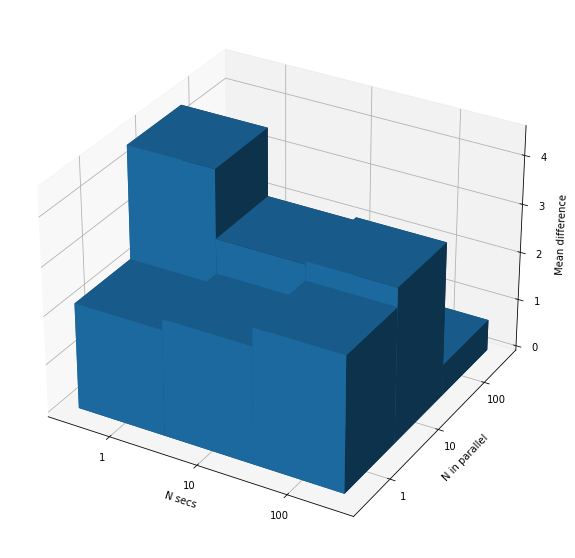

In [5]:
for model_idx in all_model_ids:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    x_data, y_data = np.meshgrid(
        np.arange(len(all_n_secs)), np.arange(len(all_n_in_parallel))
    )
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = np.zeros((len(all_n_secs), len(all_n_in_parallel)))
    for x_idx, n_secs in enumerate(all_n_secs):
        for y_idx, n_in_parallel in enumerate(all_n_in_parallel):
            z_data[x_idx, y_idx] = (
                all_jax_ys[model_idx][n_secs][n_in_parallel]
                - all_py_ys[model_idx][n_secs][n_in_parallel]
            ).mean()
    z_data = np.nan_to_num(z_data.flatten())
    ax.bar3d(x_data, y_data, np.zeros(len(z_data)), 1, 1, z_data)
    ax.w_xaxis.set_ticklabels(all_n_secs)
    ax.w_yaxis.set_ticklabels(all_n_in_parallel)
    ax.set_xlabel("N secs")
    ax.set_ylabel("N in parallel")
    ax.set_zlabel("Mean difference")
    plt.xticks(np.arange(len(all_n_secs)) + 0.5, all_n_secs)
    plt.yticks(np.arange(len(all_n_in_parallel)) + 0.5, all_n_in_parallel)
    plt.show()

### Compare Computation Time

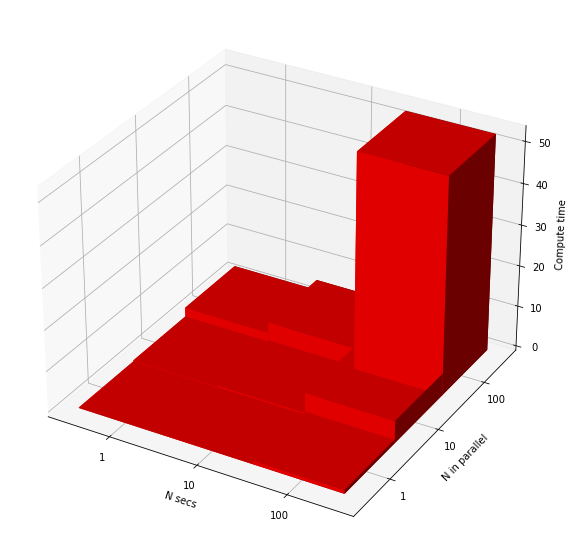

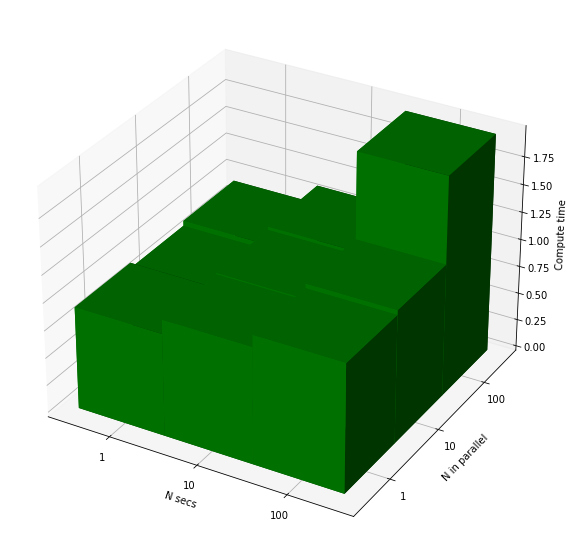

In [6]:
for model_idx in all_model_ids:

    x_data, y_data = np.meshgrid(
        np.arange(len(all_n_secs)), np.arange(len(all_n_in_parallel))
    )
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_pydata = np.zeros((len(all_n_secs), len(all_n_in_parallel)))
    z_jaxdata = np.zeros((len(all_n_secs), len(all_n_in_parallel)))
    for x_idx, n_secs in enumerate(all_n_secs):
        for y_idx, n_in_parallel in enumerate(all_n_in_parallel):
            z_pydata[x_idx, y_idx] = all_py_ctimes[model_idx][n_secs][n_in_parallel]
            z_jaxdata[x_idx, y_idx] = all_jax_ctimes[model_idx][n_secs][n_in_parallel]
    z_pydata = np.nan_to_num(z_pydata.flatten())
    z_jaxdata = np.nan_to_num(z_jaxdata.flatten())

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.bar3d(x_data, y_data, np.zeros(len(z_data)), 1, 1, z_pydata, color="red")
    ax.w_xaxis.set_ticklabels(all_n_secs)
    ax.w_yaxis.set_ticklabels(all_n_in_parallel)
    ax.set_xlabel("N secs")
    ax.set_ylabel("N in parallel")
    ax.set_zlabel("Compute time")
    plt.xticks(np.arange(len(all_n_secs)) + 0.5, all_n_secs)
    plt.yticks(np.arange(len(all_n_in_parallel)) + 0.5, all_n_in_parallel)
    plt.show()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.bar3d(x_data, y_data, np.zeros(len(z_data)), 1, 1, z_jaxdata, color="green")
    ax.w_xaxis.set_ticklabels(all_n_secs)
    ax.w_yaxis.set_ticklabels(all_n_in_parallel)
    ax.set_xlabel("N secs")
    ax.set_ylabel("N in parallel")
    ax.set_zlabel("Compute time")
    plt.xticks(np.arange(len(all_n_secs)) + 0.5, all_n_secs)
    plt.yticks(np.arange(len(all_n_in_parallel)) + 0.5, all_n_in_parallel)
    plt.show()